## YOLO이용한 객체 탐지, 분할 그리고 길이 측정 

### 왜 yolo를 택했는가
- ultralytics가 이용 편리성, 신뢰성
- ultralytics는 몇가지 모델을 제공: YOLO, SAM


-> 샘플이미지 1개로 이미지 분할 실험을 진행.

In [ ]:
from ultralytics import YOLO, SAM
import cv2
import numpy as np
import matplotlib.pyplot as plt
import openai
import json

yolo_model = YOLO("yolo11n-seg.pt")
# yolo_model.train('')

results = yolo_model(['p1.jpg'])

results


0: 288x640 1 cup, 1 bed, 1 tv, 1 keyboard, 4 books, 128.2ms
1: 288x640 1 cup, 128.2ms
Speed: 3.8ms preprocess, 128.2ms inference, 11.8ms postprocess per image at shape (1, 3, 288, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: ultralytics.engine.results.Masks object
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 

In [ ]:
def show_box(box, ax, color='red'):
    x0, y0, x1, y1 = box  # correct interpretation
    w = x1 - x0
    h = y1 - y0
    rect = plt.Rectangle((x0, y0), w, h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

def visualize_segmented_images(image, results):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    for r in results[0].boxes.data.cpu().numpy():
        show_box(r[:-2], ax)

    ax.axis('off')
    plt.tight_layout()
    plt.show()


In [83]:
boxes = results[0].boxes
cls = boxes.cls.cpu().numpy().astype(int)
cls

array([62, 66, 59, 73, 73, 41, 73, 73])

## CLIP 모델이용 레이블링 및 치수 파악

yolo 모델은 label이 지원. 

=> 레이블 세트가 한정.

=> CLIP을 이용해 레이블링을 진행하는게 좋다고 판단.

In [ ]:
results[0].namess

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [ ]:
%uv pip install git+https://github.com/openai/CLIP.git

In [67]:
for c in cls:
	print(results[0].names[c])

tv
keyboard
cup
book
book
book
bed
book
book
cup
book


In [ ]:
from transformers import CLIPForImageClassification

In [ ]:
from ultralytics import YOLO
from PIL import Image
import torch
import clip
import torchvision.transforms as T

clip_model, preprocess = clip.load("ViT-B/32", device="cpu")

# Run detection
results = yolo_model("test_images/chair1.jpg")
boxes = results[0].boxes.xyxy.cpu().numpy()

# Crop boxes and run CLIP
image = Image.open("test_images/chair1.jpg").convert("RGB")
texts = ["chair", "sofa", "bed", "gaming chair", "lamp", "monitor"]

for box in boxes:
    x1, y1, x2, y2 = map(int, box)
    crop = image.crop((x1, y1, x2, y2))
    crop_tensor = preprocess(crop).unsqueeze(0).to("cpu")

    with torch.no_grad():
        image_feat = clip_model.encode_image(crop_tensor)
        text_feat = clip_model.encode_text(clip.tokenize(texts).to("cpu"))
        probs = (image_feat @ text_feat.T).softmax(dim=-1)

    pred = texts[probs.argmax()]
    print(f"Box: {box} → Label: {pred}")



image 1/1 /Users/brad/imagegenpoc/p1.jpg: 288x640 2 cups, 1 bed, 1 tv, 1 keyboard, 6 books, 73.3ms
Speed: 3.6ms preprocess, 73.3ms inference, 1.2ms postprocess per image at shape (1, 3, 288, 640)
Box: [     1507.6      184.28        2329      716.14] → Label: monitor
Box: [     1558.5      759.32      2314.9      882.73] → Label: monitor
Box: [     1036.6      742.19      1238.8      956.42] → Label: monitor
Box: [     199.23      156.56      380.03      730.04] → Label: monitor
Box: [    0.25739      1044.6      199.71      1294.9] → Label: monitor
Box: [     1.5569      109.93      284.48      790.68] → Label: monitor
Box: [     3198.4      1204.9        4032        1812] → Label: bed
Box: [     56.768      946.14      508.39      1607.2] → Label: monitor
Box: [     330.38      833.28      642.23      1535.8] → Label: monitor
Box: [      790.2      610.53      1010.4      985.32] → Label: monitor
Box: [     167.14      153.07      325.27       744.2] → Label: monitor


레이블링 자체는 가능, 그치만 박스 인식이 덜됨. 데이터세트 문제?

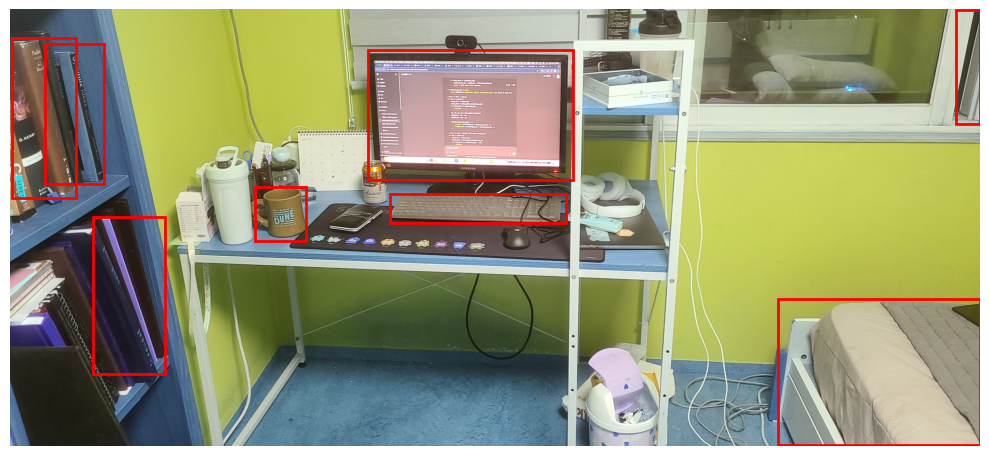

In [84]:
visualize_segmented_images(results[0].orig_img, results)

In [63]:
boxes.cls.cpu().numpy().astype(dtype=int)

array([62, 66, 41, 73, 73, 73, 59, 73, 73, 41, 73])

In [47]:
scale_px_per_mm

1.9176123046875

### 레이블 매칭을 이용한 치수 파악

레이블 매칭이 가능하다는 점에 착안하여 
1. 2개의 관점에서 찍은 사진을 객체 인식및 yolo로 사진을 절편하기
2. clip으로 레이블링한다.
3. 레이블로 매칭
4. 참고길이로 치수 파악

실험해봤습니다.

크로핑 함수로 result속 박스에 담겨있는 상자를 numpy로 절편합니다.

In [85]:
def extract_crops(image, results):
    cropped_imgs = []
    for r in results[0].boxes.data.cpu().numpy():
        x0, y0, x1, y1 = r[:-2]
        x0, x1 = np.clip([x0, x1], 0, image.shape[1])
        y0, y1 = np.clip([y0, y1], 0, image.shape[0])
        img = image[int(y0):int(y1), int(x0):int(x1)]
        cropped_imgs.append(img)
    return cropped_imgs


In [ ]:
import base64, io
from PIL import Image

results = yolo_model(['p1.jpg', 'p2.jpg'])

#### 절편 결과


0: 288x640 1 cup, 1 bed, 1 tv, 1 keyboard, 4 books, 131.0ms
1: 288x640 1 cup, 131.0ms
Speed: 5.8ms preprocess, 131.0ms inference, 11.1ms postprocess per image at shape (1, 3, 288, 640)


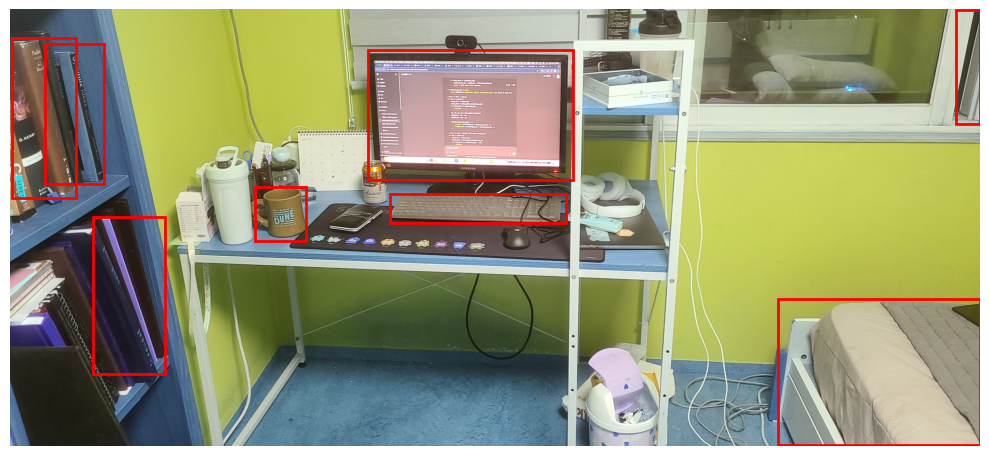

In [ ]:
visualize_segmented_images(results[0].orig_img, results)

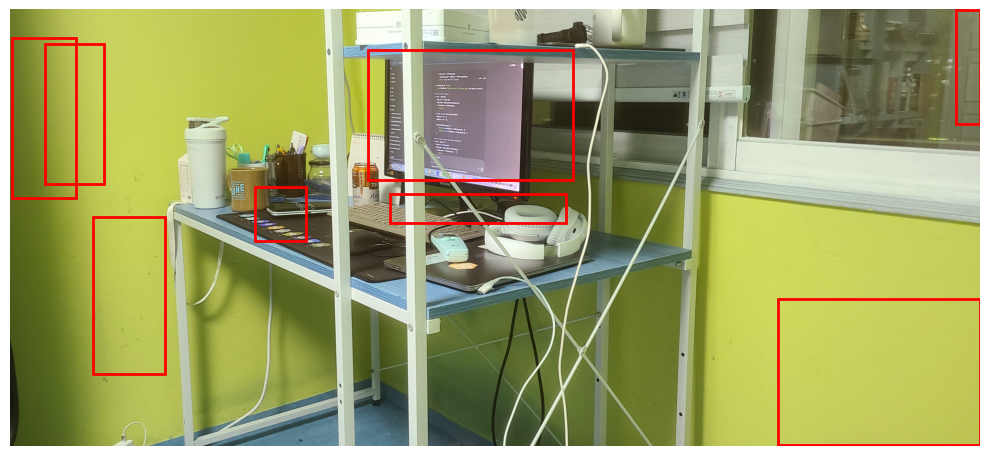

In [87]:
visualize_segmented_images(results[1].orig_img, results)

이렇게 객체인식이 됩니다. 

In [ ]:
import clip
import torch
from PIL import Image

In [ ]:
# Load CLIP once (outside the function)
clip_model, preprocess = clip.load("ViT-B/32", device="cpu")
text_tokens = clip.tokenize(["chair", "sofa", "bed", "lamp", "monitor", "table"])
text_labels = ["chair", "sofa", "bed", "lamp", "monitor", "table"]

클립으로 분류 태깅하는 함수

In [33]:

def classify_with_clip(crop):
    image_tensor = preprocess(crop).unsqueeze(0).to("cpu")
    with torch.no_grad():
        image_features = clip_model.encode_image(image_tensor)
        text_features = clip_model.encode_text(text_tokens)
        probs = (image_features @ text_features.T).softmax(dim=-1)
        best_idx = probs.argmax().item()
        return text_labels[best_idx]

레이블로 태깅 매치시키고 레프런스 `reference_obj_clip_name` 및 `reference_width_mm`를 통해 나머지 길이을 구합니다. 

In [ ]:


def get_dimensions_with_clip(boxes, images, reference_width_mm, reference_obj_clip_name):
    scale_px_per_mm = None
    dimensions = {}

    # Pass 1: Calculate scale using reference object in view 0
    for box in boxes[0]:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        crop = Image.fromarray(images[0][y1:y2, x1:x2][..., ::-1])  # BGR → RGB
        class_name = classify_with_clip(crop)
        width_px = x2 - x1

        if class_name == reference_obj_clip_name:
            scale_px_per_mm = width_px / reference_width_mm
            break

    if scale_px_per_mm is None:
        raise ValueError(f"Reference object '{reference_obj_clip_name}' not found in view 0.")

    # Pass 2: View 0 dimensions
    for box in boxes[0]:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        crop = Image.fromarray(images[0][y1:y2, x1:x2][..., ::-1])
        class_name = classify_with_clip(crop)
        if class_name == reference_obj_clip_name:
            continue

        width_px = x2 - x1
        height_px = y2 - y1
        dimensions[class_name] = {
            "w1_mm": round(width_px / scale_px_per_mm, 2),
            "height_mm": round(height_px / scale_px_per_mm, 2)
        }

    # Pass 3: View 1 widths
    for box in boxes[1]:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        crop = Image.fromarray(images[1][y1:y2, x1:x2][..., ::-1])
        class_name = classify_with_clip(crop)
        if class_name == reference_obj_clip_name:
            continue

        width_px = x2 - x1
        if class_name in dimensions:
            dimensions[class_name]["w2_mm"] = round(width_px / scale_px_per_mm, 2)

    # Final pass: Compute width and depth
    for dims in dimensions.values():
        if "w1_mm" in dims and "w2_mm" in dims:
            dims["width_mm"] = round(max(dims["w1_mm"], dims["w2_mm"]), 2)
            dims["depth_mm"] = round(min(dims["w1_mm"], dims["w2_mm"]), 2)

    return dimensions

In [75]:
# After YOLO inference
results = yolo_model(['p1.jpg', 'p2.jpg'])
boxes = [results[0].boxes, results[1].boxes]

# Also load original BGR images (for cropping)
import cv2
images = [cv2.imread("p1.jpg"), cv2.imread("p2.jpg")]

# Run dimension estimator
dims = get_dimensions_with_clip(
    boxes=boxes,
    images=images,
    reference_width_mm=1530,
    reference_obj_clip_name="bed"
)
dims


0: 288x640 2 cups, 1 bed, 1 tv, 1 keyboard, 6 books, 85.9ms
1: 288x640 1 bowl, 85.9ms
Speed: 4.9ms preprocess, 85.9ms inference, 3.1ms postprocess per image at shape (1, 3, 288, 640)


{'monitor': {'w1_mm': 289.86,
  'height_mm': 1084.21,
  'w2_mm': 416.44,
  'width_mm': 416.44,
  'depth_mm': 289.86},
 'table': {'w1_mm': 572.37, 'height_mm': 1287.84}}

## 2개 이미지로 생성 결과
- 비교적 효과적이지만 태그 미스매치 발생륩 매우 높음.
- 객체분할과 인식율 미스가 높다.

## 추후 방향
- yolo와 sam중 세그멘테이션 성능 비교
- 이걸 쓰다면 소규모 데이터세트로 훈련 패러미터 조정 요함
- 세그멘테이션만 이용하는것
- consine similarity 이용

segmentation 활용:

In [41]:
def show_box(box, ax, color='red'):
    x0, y0, x1, y1 = box  # correct interpretation
    w = x1 - x0
    h = y1 - y0
    rect = plt.Rectangle((x0, y0), w, h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

def visualize_segmented_images(image, results):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    for r in results[0].boxes.data.cpu().numpy():
        show_box(r[:-2], ax)

    ax.axis('off')
    plt.tight_layout()
    plt.show()

In [43]:
from ultralytics import YOLO
from PIL import Image
import torch
import clip
import torchvision.transforms as T

clip_model, preprocess = clip.load("ViT-B/32", device="cpu")

# Run detection
results = yolo_model("test_images/chair1.jpg")
boxes = results[0].boxes.xyxy.cpu().numpy()

# Crop boxes and run CLIP
image = Image.open("test_images/chair1.jpg").convert("RGB")
# list made by gpt
# TODO: a 빼는게 좋음. 이미 단수로 학습됨
# TODO: CLIP 자체 태그 인식하도록 할것
texts = [
    "Room full of objects"
]


for box in boxes:
    x1, y1, x2, y2 = map(int, box)
    crop = image.crop((x1, y1, x2, y2))
    crop_tensor = preprocess(crop).unsqueeze(0).to("cpu")

    with torch.no_grad():
        image_feat = clip_model.encode_image(crop_tensor)
        # TODO: clip annotation 사용할것
        text_feat = clip_model.encode_text(clip.tokenize(texts).to("cpu"))
        probs = (image_feat @ text_feat.T).softmax(dim=-1)

    pred = texts[probs.argmax()]
    print(f"Box: {box} → Label: {pred}")
    # TODO:  



image 1/1 /Users/brad/imagegenpoc/test_images/chair1.jpg: 640x288 1 chair, 1 bed, 84.0ms
Speed: 3.0ms preprocess, 84.0ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 288)
Box: [     109.99      1208.1       766.8      2095.8] → Label: Room full of objects
Box: [     222.16      994.36        1077      1473.1] → Label: Room full of objects


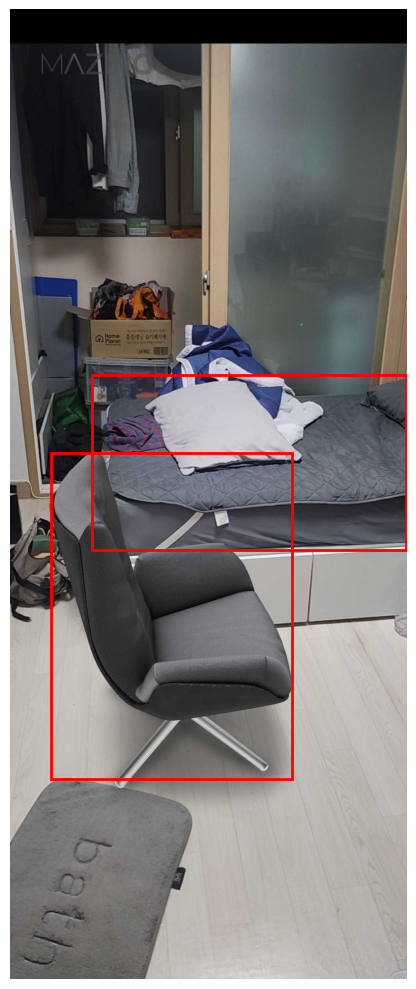

In [ ]:
# TODO:여기 있는 객체 모두 인식되도록. 싹 다
visualize_segmented_images(image, results)